# Setting up environment and imports

In [3]:
!pip install matplotlib scikit-learn
!pip install numpy==1.26


[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
import numpy as np
import torch
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import random
import pickle

print(np.__version__)

1.26.0


# Checking environment and file types

In [21]:
import torch
print(torch.__version__)
print(os.getcwd())

2.3.0+cu118
c:\Users\o0mel\GitHub\word2vec\notebooks


In [12]:
import os
path = "../artifacts/skipgram_embeddings.pt"  # make sure this matches your actual file

print("Exists:", os.path.exists(path))
print("Size (bytes):", os.path.getsize(path) if os.path.exists(path) else "N/A")

with open(path, "rb") as f:
    head = f.read(20)
print("First 20 bytes:", head)

Exists: True
Size (bytes): 24001240
First 20 bytes: b'PK\x03\x04\x00\x00\x08\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'


In [16]:
import torch

embeds = torch.load("../skipgram_embeddings.pt")
print(type(embeds))          # torch.Tensor
print(embeds.shape)          # (vocab_size, embedding_dim)
print(embeds[0][:5])         # First 5 dimensions of the first word

<class 'torch.Tensor'>
torch.Size([60000, 100])
tensor([ 1.3355,  1.6980,  2.4018, -0.6076,  0.0764], device='cuda:0')


In [17]:
import pickle
import torch

embeddings = torch.load("../skipgram_embeddings.pt")
print(f"Loaded embeddings shape: {embeddings.shape}")
print(f"Type: {type(embeddings)}")  # Should be torch.Tensor

Loaded embeddings shape: torch.Size([60000, 100])
Type: <class 'torch.Tensor'>


In [13]:
import zipfile
import os

zip_path = "../artifacts/skipgram_embeddings.pt"
extract_dir = "../artifacts/skipgram_embeddings_unzipped"

# Create directory if not exists
os.makedirs(extract_dir, exist_ok=True)

# Extract all files
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Files extracted to:", extract_dir)

Files extracted to: ../artifacts/skipgram_embeddings_unzipped


# Load saved data

In [40]:
# Load saved data
embeddings = torch.load("../artifacts/skipgram_embeddings.pt")

with open("../artifacts/word_to_index.pkl", "rb") as f:
    word_to_index = pickle.load(f)

with open("../artifacts/index_to_word.pkl", "rb") as f:
    index_to_word = pickle.load(f)

# Visualisations

##  Visualisation A] 200 Common Words

In [41]:
num_words = 200
words = list(word_to_index.keys())[1:num_words+1] # skip <UNK> token

In [42]:
vectors = torch.stack([embeddings[word_to_index[word]] for word in words])

In [43]:
tsne = TSNE(n_components=2, perplexity=30, init='random', random_state=42)
reduced = tsne.fit_transform(vectors.cpu().numpy().astype("float64"))

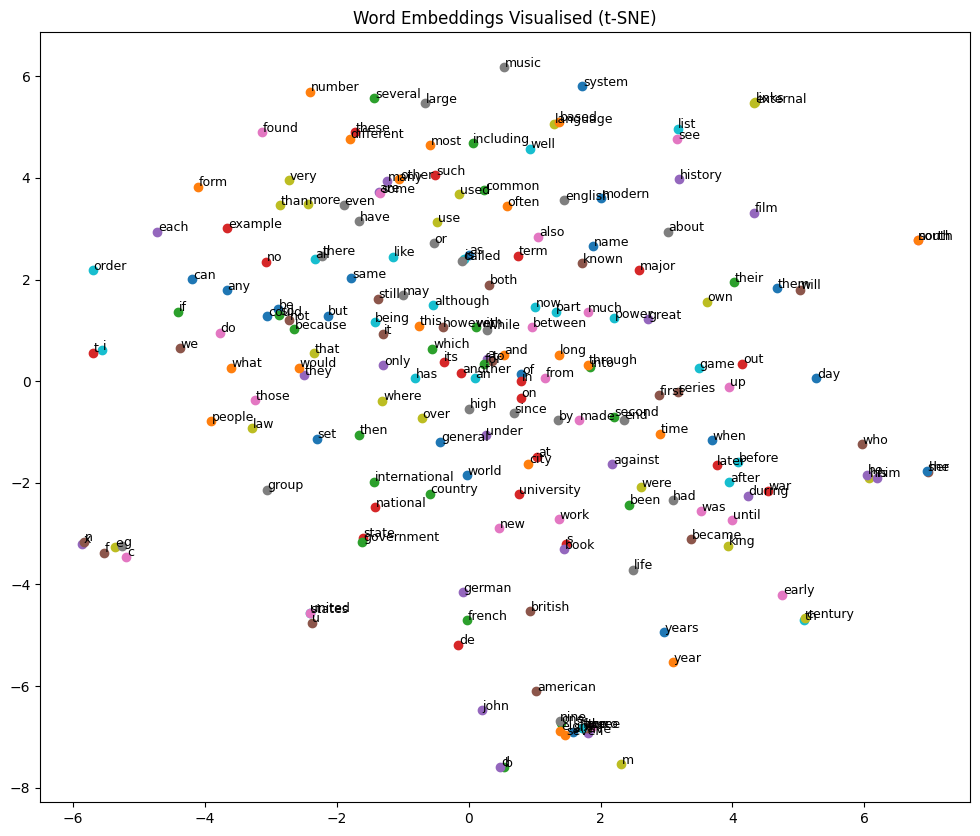

In [44]:
# Plot
plt.figure(figsize=(12, 10))
for i, word in enumerate(words):
    x, y = reduced[i]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, word, fontsize=9)
plt.title("Word Embeddings Visualised (t-SNE)")
plt.show()

## Visualiation B] Semantic Categories
Displaying the vectors of specific categories of words:
`animals`, `countries`, `colours`, `emotions`

In [46]:
categories = {
    "animals": ["cat", "dog", "horse", "lion", "tiger", "monkey", "elephant"],
    "countries": ["france", "germany", "italy", "japan", "china", "brazil", "india"],
    "colors": ["red", "blue", "green", "yellow", "black", "white", "purple"],
    "emotions": ["happy", "sad", "angry", "excited", "bored", "afraid"],
    "family": ["man", "woman", "king", "queen", "child", "mother", "father"]
}

In [48]:
words, vectors, colours = [], [], []
colour_map = {"animals": "orange", "countries": "blue", "colors": "green", "emotions": "red", "family": "purple"}

In [49]:
for category, word_list in categories.items():
    for word in word_list:
        if word in word_to_index:
            index = word_to_index[word]
            words.append(word)
            vectors.append(embeddings[index])
            colours.append(colour_map[category])

In [50]:
# Convert to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
reduced = tsne.fit_transform(torch.stack(vectors).cpu().numpy().astype("float64"))

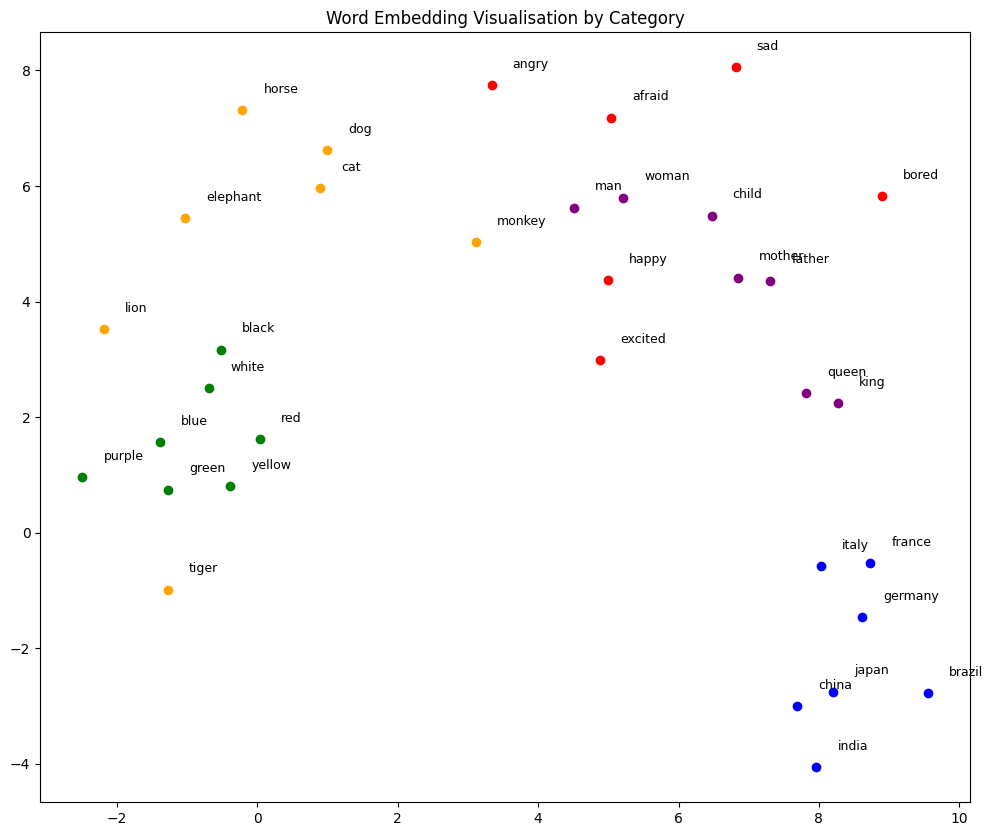

In [51]:
# Plot
plt.figure(figsize=(12, 10))
for i, word in enumerate(words):
    x, y = reduced[i]
    plt.scatter(x, y, c=colours[i])
    plt.text(x + 0.3, y + 0.3, word, fontsize=9)

plt.title("Word Embedding Visualisation by Category")
plt.show()

## Visualisation C] Word Vector Arithmetic
Showing the positions of words like the famous:

`king - max + woman ~ queen`

`paris - france + italy ~ rome`

In [53]:
def get_vector(word):
    return embeddings[word_to_index[word]]

In [54]:
# Arithmetic: king - man + woman ≈ ?
words = ["king", "man", "woman", "queen"]
vecs = [get_vector(w) for w in words]

In [55]:
# Do arithmetic
result = get_vector("king") - get_vector("man") + get_vector("woman")
vecs.append(result)
words.append("king - man + woman")

In [56]:
# Reduce to 2D
pca = PCA(n_components=2)
reduced = pca.fit_transform(torch.stack(vecs).cpu().numpy().astype("float64"))


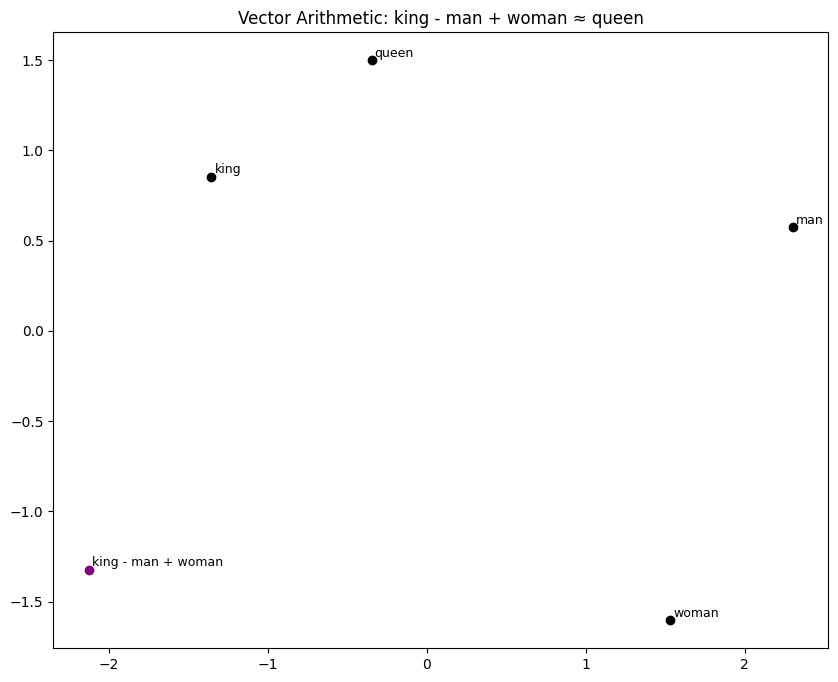

In [57]:
# Plot
plt.figure(figsize=(10, 8))
for i, word in enumerate(words):
    x, y = reduced[i]
    plt.scatter(x, y, c="purple" if " " in word else "black")
    plt.text(x + 0.02, y + 0.02, word, fontsize=9)
plt.title("Vector Arithmetic: king - man + woman ≈ queen")
plt.show()

In [58]:
def solve_analogy(a, b, c, top_k=5):
    vec = get_vector(a) - get_vector(b) + get_vector(c)
    similarities = torch.nn.functional.cosine_similarity(vec.unsqueeze(0), embeddings)
    top_indices = similarities.topk(top_k + 3).indices  # +3 in case inputs are included

    print(f"{a} - {b} + {c} ≈")
    for index in top_indices:
        word = index_to_word[index.item()]
        if word not in [a, b, c]:
            print(f"  {word}")